CIFAR-10-CLASSIFCATION MODEL

In [2]:
import tensorflow as tf
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
def unpickle(file): # - http://www.cs.toronto.edu/~kriz/cifar.html - this will open the file and return a dictionary 
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
dataset = unpickle("cifar-10-batches-py\data_batch_1") # loading data_batch_1 into the variable dataset
metadata = unpickle(r"cifar-10-batches-py\batches.meta") # These are the label names

Instead of importing the dataset directly, I decided to install it as a zip from online, to practice loading and wrangling the data

The website source of the dataset states:

 **data** -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [5]:
print(dataset.keys(),
metadata.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames']) dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


We can see the the relevant items in the dataset and metadata dictionary

In [6]:
labels = dataset[b'labels']
data = dataset[b'data']

In [7]:
len(data)
len(labels)

10000

As you can see, there are 10000 images + labels in our dataset. I will split the dataset in 80-20 training-testing into the following variables:

In [8]:
X_train = data[:8000]
X_test = data[8000:10000]

y_train = labels[:8000]
y_test = labels[8000:10000]

In [9]:
metadata.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [44]:
keys = metadata[b'label_names']
keys

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

a label of 0 should be a airplane, a label of 1 should be of a automobile

In [11]:
y_train[0]
# plt.imshow(X_train[0]) # This line throws a TypeError: Invalid shape (3072,) for image data. I realized, this is actually a 32 x 32 size image with RGB, however since there is nothing delimiting the rows
# So it just shows as 3072 - The images seem to have flattened, meaning I would need to "unflattern" them if I want to view them
# https://stackoverflow.com/questions/36967920/numpy-flatten-rgb-image-array 


6

In [12]:
test = X_train[0]

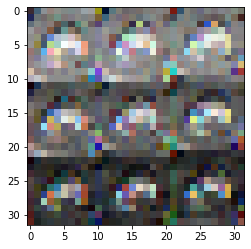

In [13]:
reshaped_image = test.reshape(32,32,3) # 32 x 32 with the 3 denoting the RGB values

plt.imshow(reshaped_image)


I'm going to have to reformat the array If I want to view the image, I will create a function that will allow me to view the image without changing the data structure of the original image

In [71]:
def show_image(index = 0, feature_data = X_train, label_data = y_train, keys = keys):
        """
        input feature, and label data, and the keys dictionary, optional param index

        displays the image + label
        """
        # The images are stored as a 3072 element vector, I need to reshape this into a tensor 
        # The image source states "The first 1024 bytes are the red channel values, the next 1024 the green,
        # and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image."
        res = feature_data[index].reshape(3,32,32) 
        #matplotlib reads the RGB channels last in the matrix. So I'm rearranging the tensor accordingly
        res = np.transpose(res, axes=[1, 2, 0]) 

        plt.imshow(res)
        plt.title(keys[label_data[index]].decode("utf-8")) # adds the label; the decode removes the b and '' from the label for a pleasant viewing experience
        plt.axis('off') # I don't want the axis to show either
        plt.show()




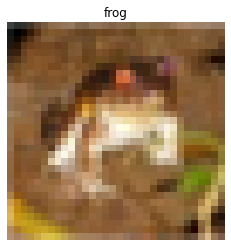

In [76]:
show_image()

Beautiful!